### imports

In [26]:
import datetime
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from h3 import h3
import folium as folium
import seaborn as sns
import geopandas as gpd
import random
import shapely.geometry as geometry
from shapely.geometry import Point,Polygon,MultiPolygon
from sklearn import metrics
from shapely import wkb,wkt
import json
from sklearn.cluster import DBSCAN,KMeans
from shapely.errors import TopologicalError
from IPython.display import Image

### Parameters

In [2]:
#DBSCAN parameters
kms_per_radian = 6371.0088
epsilon = 0.5 / kms_per_radian
orders_for_dense=20 # orders within 500 metres radius

hex_hexx_comb_threshold=10 #10 out of 28 days, in feb should have hex assoc hex
total_densest_needed=15

In [3]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=1,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=1,color=color)
    m.add_child(my_PolyLine)
    return m

### Data

In [4]:
customers=pd.read_csv('data.csv')
customers['hexagon']=customers.apply(lambda x : h3.geo_to_h3(x['lat'], x['long'], 9), axis=1)

In [5]:
customers.loc[0,"lat"]

23.763594706328934

In [6]:
#customers=customers.sample(100000)

In [7]:
all_hexs=pd.DataFrame()
all_hexs['hex_id']=list(customers['hexagon'].unique())

### hex_hex_relation stores count of the hexagon hexagon combinations in clustering results over time

In [8]:
def get_hex_hex_rel(hex_id,hex_hex_nbr_map):
    clstr_id=hex_cluster_map[hex_id]
    for nbr in list(h3.k_ring_distances(hex_id, 1)[1]):
        if nbr in cluster_hex_map[clstr_id]:
            hex_hex_nbr_map[hexx][nbr]+=1
    return hex_hex_nbr_map

In [9]:
hex_hex_nbr_map={}
for hexx in all_hexs["hex_id"]:
    hex_hex_nbr_map[hexx]={}
    for nbr in list(h3.k_ring_distances(hexx, 1)[1]):
        hex_hex_nbr_map[hexx][nbr]=0

In [10]:
for date in customers.curr_date.unique():
    custs_on_day=customers[customers["curr_date"]==date].reset_index(drop=True)
    ordercoords=custs_on_day.loc[:,["lat","long"]].values.tolist()
    custs_on_day['cluster'] =DBSCAN(eps=epsilon, min_samples=orders_for_dense, algorithm='ball_tree',
                            metric='haversine').fit_predict(np.radians(ordercoords))
    
    #hexagon is assigned to the cluster, which corresponds to max freq cluster as per orders in a hexagon.
    hex_cluster_mapper = list(custs_on_day.groupby(["hexagon","cluster"])
                  ['curr_date'].count().sort_values().groupby(level=0).tail(1).index)
    hex_cluster_map={}
    for i in hex_cluster_mapper:
        hex_cluster_map[i[0]]=i[1]
        
        
    cluster_hex_map={}
    covered_hexs=[]
    for i in hex_cluster_mapper:
        if(i[1]!=-1):
            covered_hexs.append(i[0])
        if(i[1] in cluster_hex_map):
            cluster_hex_map[i[1]].append(i[0])
        else:
            cluster_hex_map[i[1]]=[i[0]]
            
            
    for hexx in covered_hexs:
        hex_hex_nbr_map=get_hex_hex_rel(hexx,hex_hex_nbr_map)

### using union find to obtain clusters from hexagons. For Each hexagon its most freq neighbour is chosen, if freq>threshold, and hexagon and beighbour become part of same set

In [11]:
parent={}
for hexx in all_hexs['hex_id']:
    parent[hexx]=-1   
    
def find(parent,hexx):
    if parent[hexx]==-1:
        return hexx
    return find(parent,parent[hexx])

def union(parent,hex_1,hex_2):
    hex_1_set=find(parent,hex_1)
    hex_2_set=find(parent,hex_2)
    if(hex_1_set!=hex_2_set):
        parent[hex_1_set]=hex_2_set
    return parent
        

for hexx in hex_hex_nbr_map:
    max_freq=hex_hexx_comb_threshold
    best_nbr=-1
    for nbr in hex_hex_nbr_map[hexx]:
        if(hex_hex_nbr_map[hexx][nbr]>max_freq):
            max_freq=hex_hex_nbr_map[hexx][nbr]
            best_nbr=nbr
    if(best_nbr!=-1):
        parent=union(parent,hexx,best_nbr)

### Cluster extraction from union sets. Set representative hex_ids are kept Cluster ids

In [12]:
cluster_dict={}
for hexx in parent:
    rep_hexx=find(parent,hexx)
    if rep_hexx in cluster_dict:
        cluster_dict[rep_hexx].add(hexx)
    else:
        cluster_dict[rep_hexx]={hexx}

### final_cluster_dict stores final clusters

In [13]:
final_cluster_dict={}
for i in cluster_dict:
    if(len(cluster_dict[i])>1):
        final_cluster_dict[i]=cluster_dict[i]

### a dataframe to store result: dataframe of hex_ids and cluster_ids

In [14]:
to_df_list=[]
for cluster_id in final_cluster_dict:
    for cluster_hexagon in final_cluster_dict[cluster_id]:
        row={}
        row["cluster_id"]=cluster_id
        row["hexagon_id"]=cluster_hexagon
        to_df_list.append(row)
cluster_df=pd.DataFrame(to_df_list)

In [15]:
cluster_df.head()

cluster_id       hexagon_id
0  893ca9c822bffff  893ca9c822bffff
1  893ca9c822bffff  893ca9c9c97ffff
2  893ca9c822bffff  893ca9c8233ffff
3  893ca9c822bffff  893ca9c9c83ffff
4  893ca9c822bffff  893ca9c826fffff

### order_counts in hexagons of consistent polygons

In [16]:
order_hex_count=customers.groupby('hexagon').size()
cluster_df["order_count"]=cluster_df['hexagon_id'].apply(lambda x:order_hex_count[x])

### order_counts in consistent clusters

In [17]:
cluster_order_count=(cluster_df.groupby('cluster_id')['order_count'].sum())
cluster_order_count=cluster_order_count//28

In [18]:
densest_clusters=list((cluster_order_count).sort_values(ascending=False).iloc[0:total_densest_needed].index)

In [19]:
cluster_order_count.sum()

3797

### Geodataframe

In [20]:
geo_dict={}
for i in final_cluster_dict:
    polygons = h3.h3_set_to_multi_polygon(final_cluster_dict[i], geo_json=False)
    outlines = [loop for polygon in polygons for loop in polygon]
    polylines = [outline + [outline[0]] for outline in outlines]
    geo_dict[i]=geometry.Polygon([[p[1], p[0]] for p in polylines[0]])
    
gdf = gpd.GeoDataFrame(crs={'init': 'epsg:4326'})
gdf["cluster_id"]=list(cluster_order_count.keys())
gdf["customer_count"]=gdf["cluster_id"].apply(lambda x:cluster_order_count[x])
gdf["geometry"]=gdf["cluster_id"].apply(lambda x:geo_dict[x])

### Plot on map

In [21]:
covered_hexs=set()
for cluster_id in final_cluster_dict:
    covered_hexs=covered_hexs.union(final_cluster_dict[cluster_id])

In [22]:
remaining_hexs=list(set(all_hexs['hex_id'])-covered_hexs)

In [23]:
mapp = folium.Map( location=[custs_on_day.lat.mean(),custs_on_day.long.mean()], zoom_start=13)
colourlist=["red","blue","green", "purple", "orange", "darkblue", "darkgreen","lightblue","darkred", "black","gray","cadetblue","darkpurple"]

for hexx in remaining_hexs:
    mapp=visualize_hexagons([hexx],color='white',folium_map=mapp)
    
colour_count=0
for i in final_cluster_dict:
    col=colourlist[colour_count%len(colourlist)]
    mapp=visualize_hexagons(final_cluster_dict[i],color=col,folium_map=mapp)
    colour_count+=1

In [24]:
mapp

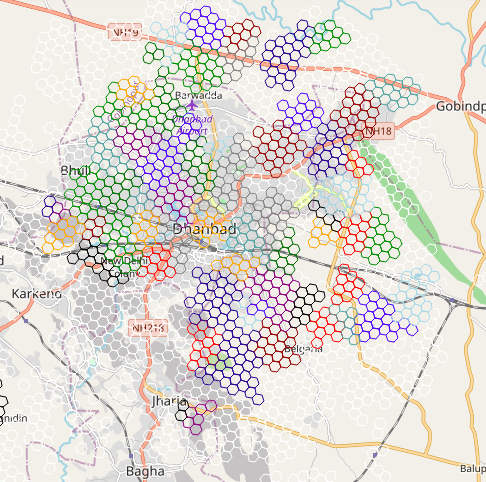

In [27]:
Image("Clusters.png") # folium plots not visible on github

In [28]:
def polycentroid(polylines):
    mean_lat=0
    mean_long=0
    for polyline in polylines:
        for point in polyline:
            mean_lat+=point[0]
            mean_long+=point[1]
        break
    return [mean_lat/len(polylines[0]),mean_long/len(polylines[0])]

In [29]:
def visualize_hexa_polys(hexagons,cluster_id,order_count,color, folium_map):
    polygons = h3.h3_set_to_multi_polygon(hexagons, geo_json=False)
    # flatten polygons into loops.
    outlines = [loop for polygon in polygons for loop in polygon]
    polylines = [outline + [outline[0]] for outline in outlines]
    m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=1,color=color)
        m.add_child(my_PolyLine)
    folium.Marker(location=polycentroid(polylines),popup="id:"+str(cluster_id)+"\n"+"avg_customers="+str(order_count), 
                  icon= folium.Icon(color=color,icon = 'home')).add_to(m)
    return m

In [30]:
mapp = folium.Map( location=[custs_on_day.lat.mean(),custs_on_day.long.mean()], zoom_start=13)
colourlist=["red","blue","green", "purple", "orange", "darkblue", "darkgreen","lightblue","darkred","gray","cadetblue"]

for hexx in remaining_hexs:
    mapp=visualize_hexagons([hexx],color='white',folium_map=mapp)
    
colour_count=0
clusterid_visibleid_map={}
for i in final_cluster_dict:
    clusterid_visibleid_map[i]=colour_count
    col= "black" if i in densest_clusters else colourlist[colour_count%len(colourlist)]
    mapp=visualize_hexa_polys(final_cluster_dict[i],colour_count,cluster_order_count[i],color=col,folium_map=mapp)
    colour_count+=1

In [31]:
mapp

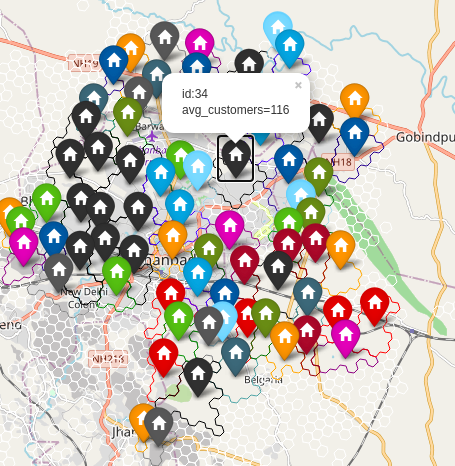

In [73]:
Image("CombinedHexagonsOfClusters.png")

In [33]:
gdf.head()

cluster_id  customer_count  \
0  893ca826403ffff              26   
1  893ca9c126fffff              42   
2  893ca9c80d3ffff              47   
3  893ca9c8117ffff              74   
4  893ca9c811bffff              48   

                                            geometry  
0  POLYGON ((86.33556 23.69437, 86.33755 23.69401...  
1  POLYGON ((86.43198 23.85011, 86.43339 23.85151...  
2  POLYGON ((86.41172 23.78125, 86.41372 23.78089...  
3  POLYGON ((86.44864 23.79439, 86.44923 23.79264...  
4  POLYGON ((86.44864 23.79439, 86.44665 23.79475...

In [34]:
gdf.to_csv('gdff.csv',index=False)

### Scores

In [35]:
orders_per_day=len(customers)//28

In [36]:
orders_per_day

4654

In [37]:
covered_orders=gdf.customer_count.sum()

In [38]:
percent_cover=covered_orders*100/orders_per_day

In [39]:
percent_cover

81.58573270305114

### orders covered on a day.

In [40]:
gdf=pd.read_csv('gdff.csv')

In [41]:
gdf['geometry'] = gdf['geometry'].apply(lambda x:wkt.loads(x))
gdf= gpd.GeoDataFrame(gdf, geometry='geometry')

In [42]:
dss=gdf.loc[0,"geometry"]
for poly in gdf.geometry:
    dss=dss.union(poly)

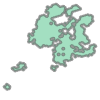

In [43]:
dss

In [44]:
days_data=customers[customers["curr_date"]=="2020-02-11"].reset_index(drop=True)

In [45]:
days_data["geometry"]=days_data.apply(lambda x:Point(x['long'],x['lat']),axis=1)

In [46]:
days_data['inside']=days_data["geometry"].apply(lambda x:1 if x.within(dss) else 0)

In [47]:
days_data['inside'].sum()

3797

In [48]:
days_data.head()

curr_date        lat       long          hexagon  \
0  2020-02-11  23.822995  86.402841  893ca9ca3d3ffff   
1  2020-02-11  23.826789  86.403064  893ca9ca06fffff   
2  2020-02-11  23.761179  86.430692  893ca9c8223ffff   
3  2020-02-11  23.751321  86.434582  893ca9c9c8bffff   
4  2020-02-11  23.839831  86.377170  893ca9ca6b7ffff   

                                      geometry  inside  
0  POINT (86.40284071635028 23.82299470632893)       1  
1  POINT (86.40306371635029 23.82678870632894)       1  
2  POINT (86.43069171635028 23.76117870632893)       1  
3  POINT (86.43458171635029 23.75132070632893)       1  
4  POINT (86.37716971635029 23.83983070632893)       0

In [49]:
len(days_data)

4608

In [50]:
percent_cover=days_data['inside'].sum()*100/len(days_data)

In [51]:
percent_cover

82.40017361111111

### test

In [52]:
customers=pd.read_csv("test.csv")
gdf=pd.read_csv('gdff.csv')
gdf['geometry'] = gdf['geometry'].apply(lambda x:wkt.loads(x))
gdf= gpd.GeoDataFrame(gdf, geometry='geometry')

In [53]:
dss=gdf.loc[0,"geometry"]
for poly in gdf.geometry:
    dss=dss.union(poly)

In [54]:
result=[]
for date in customers.curr_date.unique():
    days_data=customers[customers["curr_date"]==date].reset_index(drop=True)
    days_data["geometry"]=days_data.apply(lambda x:Point(x['long'],x['lat']),axis=1)
    days_data['inside']=days_data["geometry"].apply(lambda x:1 if x.within(dss) else 0)
    result.append(100*days_data['inside'].sum()/len(days_data))

In [55]:
result

[81.97486535008977,
 81.56201078448426,
 80.69434239529758,
 81.46270818247646,
 81.36623748211731,
 81.26795977011494,
 79.19383521043272,
 83.68533229994188,
 80.6044376434583,
 79.92482865354853,
 80.21266759130837,
 79.9124726477024,
 80.09971818773033,
 79.96473440599515]

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

In [57]:
plotdf=pd.DataFrame()
plotdf["date"]=customers.curr_date.unique()
plotdf["percentage_customer_cover"]=result

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 <a list of 14 Text major ticklabel objects>)

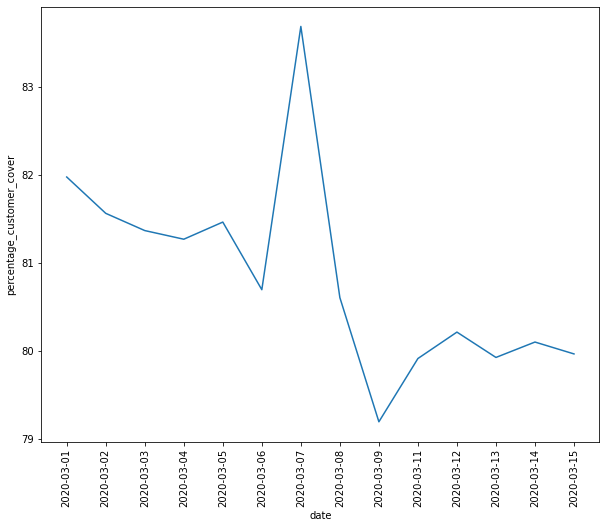

In [58]:
f, ax = plt.subplots(figsize=(10, 8))
fig=sns.lineplot(x="date", y="percentage_customer_cover",
             data=plotdf)
plt.xticks(rotation=90)

In [59]:
pd.Series(result).describe()

count    14.000000
mean     80.851868
std       1.141627
min      79.193835
25%      79.998480
50%      80.649390
75%      81.438591
max      83.685332
dtype: float64

### Calinski measure

In [60]:
customers=pd.read_csv("test.csv")
gdf=pd.read_csv('gdff.csv')
gdf['geometry'] = gdf['geometry'].apply(lambda x:wkt.loads(x))
gdf= gpd.GeoDataFrame(gdf, geometry='geometry')

In [61]:
gdf.head()

cluster_id  customer_count  \
0  893ca826403ffff              26   
1  893ca9c126fffff              42   
2  893ca9c80d3ffff              47   
3  893ca9c8117ffff              74   
4  893ca9c811bffff              48   

                                            geometry  
0  POLYGON ((86.33556 23.69437, 86.33755 23.69401...  
1  POLYGON ((86.43198 23.85011, 86.43339 23.85151...  
2  POLYGON ((86.41172 23.78125, 86.41372 23.78089...  
3  POLYGON ((86.44864 23.79439, 86.44923 23.79264...  
4  POLYGON ((86.44864 23.79439, 86.44665 23.79475...

In [62]:
Cal_test=customers[customers["curr_date"]=='2020-03-06'].reset_index(drop=True).loc[:,["lat","long"]]

In [63]:
def get_label(geom):
    gdf["inside"]=gdf["geometry"].apply(lambda x:1 if geom.within(x) else 0)
    temp= gdf[gdf["inside"]==1]
    if(len(temp)>0):
        return temp.iloc[0]["cluster_id"]
    return -1

In [64]:
Cal_test["geometry"]=Cal_test.apply(lambda x:Point(x['long'],x['lat']),axis=1)
Cal_test['label']=Cal_test["geometry"].apply(lambda geom:get_label(geom))

In [65]:
Cal_test.head(10)

lat       long                                     geometry  \
0  23.792005  86.328359  POINT (86.32835891317394 23.79200507309994)   
1  23.803813  86.412755  POINT (86.41275491317396 23.80381307309994)   
2  23.798072  86.419475  POINT (86.41947491317394 23.79807207309993)   
3  23.829752  86.498006  POINT (86.49800591317396 23.82975207309994)   
4  23.798404  86.444816  POINT (86.44481591317397 23.79840407309993)   
5  23.816560  86.479311  POINT (86.47931091317396 23.81656007309994)   
6  23.801843  86.453811  POINT (86.45381091317397 23.80184307309994)   
7  23.793799  86.392988  POINT (86.39298791317397 23.79379907309994)   
8  23.778376  86.434016  POINT (86.43401591317397 23.77837607309994)   
9  23.755529  86.405431  POINT (86.40543091317394 23.75552907309994)   

             label  
0               -1  
1  893ca9c84bbffff  
2  893ca9c85dbffff  
3  893ca9cf68bffff  
4  893ca9c811bffff  
5  893ca9cab1bffff  
6  893ca9c8117ffff  
7  893ca9cb1afffff  
8  893ca9c8393ffff  
9               -1

In [66]:
Cal_test=Cal_test[~(Cal_test["label"]==-1)].reset_index(drop=True)

In [67]:
Cal_test.head(10)

lat       long                                     geometry  \
0  23.803813  86.412755  POINT (86.41275491317396 23.80381307309994)   
1  23.798072  86.419475  POINT (86.41947491317394 23.79807207309993)   
2  23.829752  86.498006  POINT (86.49800591317396 23.82975207309994)   
3  23.798404  86.444816  POINT (86.44481591317397 23.79840407309993)   
4  23.816560  86.479311  POINT (86.47931091317396 23.81656007309994)   
5  23.801843  86.453811  POINT (86.45381091317397 23.80184307309994)   
6  23.793799  86.392988  POINT (86.39298791317397 23.79379907309994)   
7  23.778376  86.434016  POINT (86.43401591317397 23.77837607309994)   
8  23.852738  86.458176  POINT (86.45817591317396 23.85273807309994)   
9  23.808258  86.402913  POINT (86.40291291317396 23.80825807309994)   

             label  
0  893ca9c84bbffff  
1  893ca9c85dbffff  
2  893ca9cf68bffff  
3  893ca9c811bffff  
4  893ca9cab1bffff  
5  893ca9c8117ffff  
6  893ca9cb1afffff  
7  893ca9c8393ffff  
8  893ca9cad4bffff  
9  893ca9c849bffff

In [68]:
labels=list(Cal_test['label'])

In [69]:
Cal_test=Cal_test.loc[:,['lat',"long"]]

In [70]:
X=Cal_test.values.tolist()

In [71]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import numpy as np

In [72]:
metrics.calinski_harabasz_score(X, labels)

5803.004869561015